<a href="https://colab.research.google.com/github/Parvina-jon/Bitcoin-price-prediction/blob/main/Corrected_Pet_project_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pet project

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install autopep8
!autopep8 --in-place "/content/drive/My Drive/Colab Notebooks/Corrected Pet project Bitcoin.ipynb"

In [ ]:
import re

!pip install dask[dataframe]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    recall_score,
    roc_auc_score,
    f1_score,
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy import stats
from scipy.stats import randint, uniform
import yfinance as yf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# –°–∫–∞—á–∏–≤–∞–µ–º –¥–∞–Ω–Ω—ã–µ —Å –∫—É—Ä—Å–∞–º–∏ –±–∏—Ç–∫–æ–∏–Ω–∞ –∫ –¥–æ–ª–ª–∞—Ä—É –≤ —Ä–∞–∑—Ä–µ–∑–µ 2014 - 2024 –≥–≥.
btc_data = yf.download(
    "BTC-USD", start="2014-09-17", end=datetime.now().strftime("%Y-%m-%d")
)
btc = yf.Ticker("BTC-USD")
btc = btc.history(period="max")
btc.index = pd.to_datetime(btc.index)  # –ø–æ–º–µ–Ω—è—Ç—å –∏–Ω–¥–µ–∫—Å—ã
btc.to_csv("BTC_USD.csv")  # —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –≤ csv format
btc  # –û—Ç–æ–±—Ä–∞–∑–∏—Ç—å –¥–∞–Ω–Ω—ã–µ

[*********************100%***********************]  1 of 1 completed


Open           High            Low  \
Date                                                                     
2014-09-17 00:00:00+00:00     465.864014     468.174011     452.421997   
2014-09-18 00:00:00+00:00     456.859985     456.859985     413.104004   
2014-09-19 00:00:00+00:00     424.102997     427.834991     384.532013   
2014-09-20 00:00:00+00:00     394.673004     423.295990     389.882996   
2014-09-21 00:00:00+00:00     408.084991     412.425995     393.181000   
...                                  ...            ...            ...   
2024-12-13 00:00:00+00:00  100046.648438  101888.804688   99233.281250   
2024-12-14 00:00:00+00:00  101451.437500  102618.882812  100634.054688   
2024-12-15 00:00:00+00:00  101373.531250  105047.539062  101227.031250   
2024-12-16 00:00:00+00:00  104293.578125  107780.578125  103322.984375   
2024-12-18 00:00:00+00:00  106052.015625  108239.414062  105534.945312   

                                   Close       Volume  Dividends  Stock Splits  
Date                                                                            
2014-09-17 00:00:00+00:00     457.334015     21056800        0.0           0.0  
2014-09-18 00:00:00+00:00     424.440002     34483200        0.0           0.0  
2014-09-19 00:00:00+00:00     394.795990     37919700        0.0           0.0  
2014-09-20 00:00:00+00:00     408.903992     36863600        0.0           0.0  
2014-09-21 00:00:00+00:00     398.821014     26580100        0.0           0.0  
...                                  ...          ...        ...           ...  
2024-12-13 00:00:00+00:00  101459.257812  56894751583        0.0           0.0  
2024-12-14 00:00:00+00:00  101372.968750  40422968793        0.0           0.0  
2024-12-15 00:00:00+00:00  104298.695312  51145914137        0.0           0.0  
2024-12-16 00:00:00+00:00  106029.718750  91020417816        0.0           0.0  
2024-12-18 00:00:00+00:00  106150.835938  68596985856        0.0           0.0  

[3745 rows x 7 columns]

In [ ]:
# –ö–æ–Ω—Å—Ç–∞–Ω—Ç—ã
START_DATE = "2014-09-17"
BITCOIN_TICKER = "BTC-USD"
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_SPLITS = 5
FUTURE_DAYS = 30
SIGNIFICANCE_LEVEL = 0.05

In [ ]:
# Feature Engineering –∫–æ–Ω—Å—Ç–∞–Ω—Ç—ã
RETURN_PERIODS = [1, 7, 30]  # –î–Ω–∏, –ø–æ –∫–æ—Ç–æ—Ä—ã–º —Ä–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ—Ç—Å—è –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç—å –∫—É—Ä—Å–∞ –±–∏—Ç–∫–æ–∏–Ω–∞
MA_PERIODS = [7, 30]  # –î–Ω–∏, –ø–æ –∫–æ—Ç–æ—Ä—ã–º —Ä–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ—Ç—Å—è —Å—Ä–µ–¥–Ω–µ–µ —Å–∫–æ–ª—å–∑—è—â–µ–µ
VOLATILITY_WINDOW = 30

In [ ]:
# –ö–æ–Ω—Å—Ç–∞–Ω—Ç—ã –º–æ–¥–µ–ª–µ–π
RF_PARAMS = {"criterion": ["entropy"], "max_depth": [5], "n_estimators": [300]}
AR_LAGS = 5
ARIMA_ORDER = (1, 1, 1)
MA_ORDER = (0, 0, 1)
ARMA_ORDER = (1, 0, 1)

In [ ]:
# –°–ø–∏—Å–æ–∫ —Ñ–∏—á–µ–π
FEATURES = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Returns",
    "Log_Returns",
    "MA_7",
    "MA_30",
    "Volatility",
]

#Exploratory Data Analysis

In [ ]:
print(btc_data.head())

Price        Adj Close       Close        High         Low        Open  \
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD     BTC-USD   
Date                                                                     
2014-09-17  457.334015  457.334015  468.174011  452.421997  465.864014   
2014-09-18  424.440002  424.440002  456.859985  413.104004  456.859985   
2014-09-19  394.795990  394.795990  427.834991  384.532013  424.102997   
2014-09-20  408.903992  408.903992  423.295990  389.882996  394.673004   
2014-09-21  398.821014  398.821014  412.425995  393.181000  408.084991   

Price         Volume  
Ticker       BTC-USD  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  


In [ ]:
print(btc_data.describe())

Price       Adj Close          Close           High            Low  \
Ticker        BTC-USD        BTC-USD        BTC-USD        BTC-USD   
count     3744.000000    3744.000000    3744.000000    3744.000000   
mean     19276.734467   19276.734467   19686.198352   18799.014401   
std      21622.848791   21622.848791   22064.759388   21096.404883   
min        178.102997     178.102997     211.731003     171.509995   
25%       1218.952515    1218.952515    1234.720032    1202.144958   
50%       9329.373535    9329.373535    9487.997070    9180.041992   
75%      30397.931152   30397.931152   30933.593262   29882.023926   
max     106029.718750  106029.718750  107780.578125  103322.984375   

Price            Open        Volume  
Ticker        BTC-USD       BTC-USD  
count     3744.000000  3.744000e+03  
mean     19249.826777  1.842792e+10  
std      21580.583582  2.017915e+10  
min        176.897003  5.914570e+06  
25%       1211.867493  3.783415e+08  
50%       9332.083496  1.454823e+

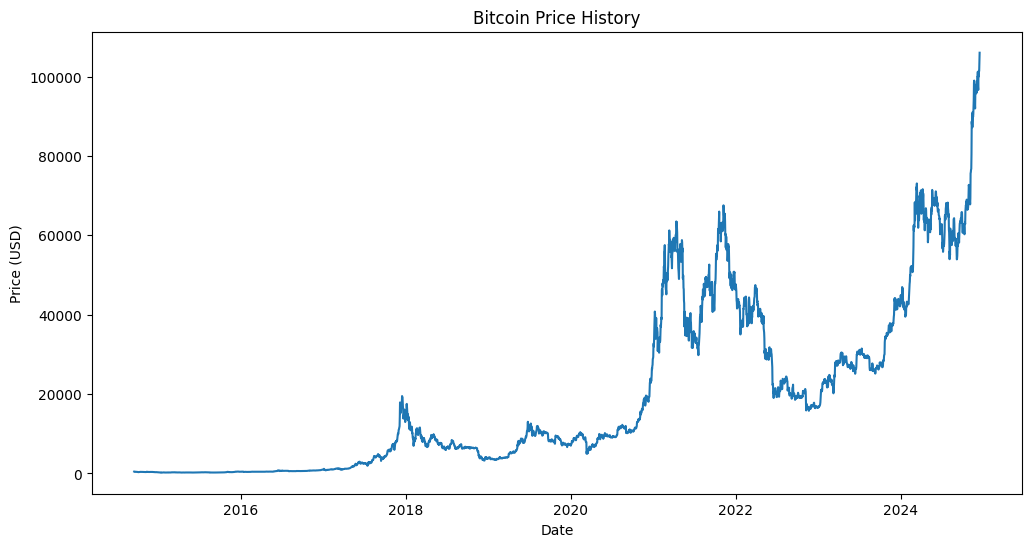

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data["Close"])
plt.title("Bitcoin Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

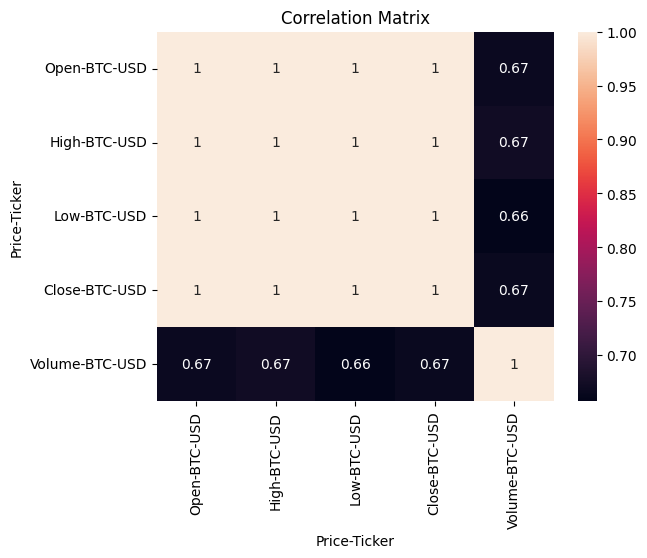

In [ ]:
correlation_matrix = btc_data[["Open", "High", "Low", "Close", "Volume"]].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

# Feature Engineering

In [ ]:
# Feature Engineering
btc_data["Returns"] = btc_data["Close"].pct_change()
btc_data["Log_Returns"] = np.log(btc_data["Close"] / btc_data["Close"].shift(1))
btc_data["MA_7"] = btc_data["Close"].rolling(window=7).mean()
btc_data["MA_30"] = btc_data["Close"].rolling(window=30).mean()
btc_data["Volatility"] = btc_data["Returns"].rolling(window=30).std()

In [ ]:
def engineer_features(data):
    """
    –°–æ–∑–¥–∞–Ω–∏–µ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö —Ñ–∏—á–µ–π –∏–∑ –Ω–µ–æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –æ —Ü–µ–Ω–∞—Ö.

    Args:
    data (pandas.DataFrame): –ù–µ–æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –æ —Ü–µ–Ω–∞—Ö.

    Returns:
    pandas.DataFrame: –î–∞–Ω–Ω—ã–µ –æ—Ü–µ–Ω–∞—Ö —Å –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–º–∏ —Ñ–∏—á–∞–º–∏.
    """
    data["Returns"] = data["Close"].pct_change()
    data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
    data["MA_7"] = data["Close"].rolling(window=7).mean()
    data["MA_30"] = data["Close"].rolling(window=30).mean()
    data["Volatility"] = data["Returns"].rolling(window=30).std()
    data["Target"] = (data["Close"].shift(-1) > data["Close"]).astype(int)
    return data.dropna()

In [ ]:
btc_data.sample(5)

Price          Adj Close         Close          High           Low  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2018-08-11   6295.729980   6295.729980   6455.740234   6109.029785   
2015-08-18    211.078995    211.078995    257.993011    211.078995   
2018-12-07   3419.937256   3419.937256   3512.590332   3280.228760   
2022-01-26  36852.121094  36852.121094  38825.410156  36374.906250   
2018-05-29   7472.589844   7472.589844   7526.419922   7090.680176   

Price               Open       Volume   Returns Log_Returns          MA_7  \
Ticker           BTC-USD      BTC-USD                                       
Date                                                                        
2018-08-11   6185.790039   4047850000  0.017951    0.017792   6589.695661   
2015-08-18    257.925995     42147200 -0.181788   -0.200634    255.035568   
2018-12-07   3512.590332   6835615448 -0.028731   -0.029152   3842.944057   
2022-01-26  36950.515625  31324598034 -0.002757   -0.002761  36986.463170   
2018-05-29   7129.459961   5662660096  0.047169    0.046091   7422.568569   

Price              MA_30 Volatility  
Ticker                               
Date                                 
2018-08-11   7285.273649   0.037707  
2015-08-18    274.821598   0.037542  
2018-12-07   4803.789803   0.050563  
2022-01-26  42420.125260   0.029170  
2018-05-29   8544.026318   0.028073

In [ ]:
# –°–æ–∑–¥–∞—Ç—å —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é (1 –µ—Å–ª–∏ —Ü–µ–Ω–∞ —Ä–∞—Å—Ç—ë—Ç, 0 –µ—Å–ª–∏ —Ü–µ–Ω–∞ –ø–∞–¥–∞–µ—Ç)
btc_data["Target"] = (btc_data["Close"].shift(-1) > btc_data["Close"]).astype(int)

In [ ]:
btc_data.sample(5)

Price          Adj Close         Close          High           Low  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2017-02-01    989.023010    989.023010    989.114014    970.742004   
2024-01-16  43154.945312  43154.945312  43566.273438  42085.996094   
2023-11-03  34732.324219  34732.324219  34942.472656  34133.441406   
2015-03-15    286.393005    286.393005    286.528992    280.996002   
2019-03-15   3960.911133   3960.911133   3968.542969   3914.015381   

Price               Open       Volume   Returns Log_Returns          MA_7  \
Ticker           BTC-USD      BTC-USD                                       
Date                                                                        
2017-02-01    970.940979    150110000  0.019188    0.019006    936.890006   
2024-01-16  42499.335938  24062872740  0.015125    0.015011  43736.442522   
2023-11-03  34942.472656  17158456701 -0.005894   -0.005911  34700.859933   
2015-03-15    281.424988     11970100  0.015992    0.015866    289.387861   
2019-03-15   3926.663330   9394210605  0.009312    0.009268   3931.613525   

Price              MA_30 Volatility Target  
Ticker                                      
Date                                        
2017-02-01    911.044965   0.051274      1  
2024-01-16  43646.949740   0.027363      0  
2023-11-03  30559.888737   0.023545      1  
2015-03-15    261.533635   0.035008      1  
2019-03-15   3874.213029   0.022811      1

In [ ]:
# Drop NaN values
btc_data.dropna(inplace=True)

In [ ]:
btc_data.sample(5)

Price          Adj Close         Close          High           Low  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2017-01-25    901.541992    901.541992    903.252014    891.687012   
2023-08-15  29170.347656  29170.347656  29439.121094  29088.853516   
2017-08-07   3378.939941   3378.939941   3397.679932   3180.889893   
2018-10-14   6290.930176   6290.930176   6363.209961   6280.149902   
2016-12-31    963.742981    963.742981    963.742981    947.236023   

Price               Open       Volume   Returns Log_Returns          MA_7  \
Ticker           BTC-USD      BTC-USD                                       
Date                                                                        
2017-01-25    891.924011    120831000  0.009919    0.009871    907.971715   
2023-08-15  29408.048828  12640195779 -0.008096   -0.008129  29380.924386   
2017-08-07   3212.780029   1482279936  0.051339    0.050064   2996.477086   
2018-10-14   6288.490234   3085320000  0.000786    0.000786   6426.877232   
2016-12-31    960.627014     99135104  0.002606    0.002603    944.484279   

Price              MA_30 Volatility Target  
Ticker                                      
Date                                        
2017-01-25    920.026363   0.051680      1  
2023-08-15  29446.733854   0.009036      0  
2017-08-07   2622.334652   0.070051      1  
2018-10-14   6530.360384   0.016289      1  
2016-12-31    830.436568   0.019591      1

In [ ]:
def test_hypothesis(data):
    """
    –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏—Ö  —Ç–µ—Å—Ç–æ–≤ –ø–æ —Ä–∞–∑–Ω—ã–º –≥–∏–ø–æ—Ç–µ–∑–∞–º –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –ø–æ–≤–µ–¥–µ–Ω–∏—è –∫—É—Ä—Å–∞ –±–∏—Ç–∫–æ–∏–Ω–∞.

    Args:
    data (pandas.DataFrame): –î–∞–Ω–Ω—ã–µ –æ —Ü–µ–Ω–∞—Ö —Å –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–º–∏ —Ñ–∏—á–∞–º–∏.

    Prints:
    –†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è –≥–∏–ø–æ—Ç–µ–∑ –≤–∫–ª—é—á–∞—è test statistics, p-values, –∏ –≤—ã–≤–æ–¥—ã.
    """
    print(" –†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è :")

In [ ]:
# –¢–µ—Å—Ç–∏—Ä—É–µ–º –≥–∏–ø–æ—Ç–µ–∑—ã

print("Hypothesis Testing Results:")

# –ì–∏–ø–æ—Ç–µ–∑–∞ 1: –£—Ä–æ–≤–µ–Ω—å –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏ –±–∏—Ç–∫–æ–∏–Ω–∞ (returns) –∏–º–µ–µ—Ç –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
h1_statistic, h1_p_value = stats.normaltest(btc_data["Returns"])
print("\n–ì–∏–ø–æ—Ç–µ–∑–∞ 1: –£—Ä–æ–≤–µ–Ω—å –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏ –±–∏—Ç–∫–æ–∏–Ω–∞ –∏–º–µ–µ—Ç –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ")
print(f"Test statistic: {h1_statistic}, p-value: {h1_p_value}")
print(
    "Conclusion: –û—Ç–∫–ª–æ–Ω–∏—Ç—å –Ω—É–ª–µ–≤—É—é –≥–∏–ø–æ—Ç–µ–∑—É"
    if h1_p_value < 0.05
    else "Conclusion: –°—É—â–µ—Å—Ç–≤—É–µ—Ç –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –Ω—É–ª–µ–≤–æ–π –≥–∏–ø–æ—Ç–µ–∑—ã"
)

Hypothesis Testing Results:

–ì–∏–ø–æ—Ç–µ–∑–∞ 1: –£—Ä–æ–≤–µ–Ω—å –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏ –±–∏—Ç–∫–æ–∏–Ω–∞ –∏–º–µ–µ—Ç –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
Test statistic: 566.8541292394582, p-value: 8.113155755839795e-124
Conclusion: –û—Ç–∫–ª–æ–Ω–∏—Ç—å –Ω—É–ª–µ–≤—É—é –≥–∏–ø–æ—Ç–µ–∑—É


In [ ]:
# –ì–∏–ø–æ—Ç–µ–∑–∞ 2: –°—É—â–µ—Å—Ç–≤—É–µ—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –º–µ–∂–¥—É –æ–±—ä–µ–º–æ–º —Ç–æ—Ä–≥–æ–≤–ª–∏ –∏ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å—é —Ü–µ–Ω
h2_correlation, h2_p_value = stats.pearsonr(
    btc_data["Volume"].values.flatten(), btc_data["Volatility"]
)
print(
    "\n–ì–∏–ø–æ—Ç–µ–∑–∞ 2: –°—É—â–µ—Å—Ç–≤—É–µ—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –º–µ–∂–¥—É –æ–±—ä–µ–º–æ–º —Ç–æ—Ä–≥–æ–≤–ª–∏ –∏ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å—é —Ü–µ–Ω."
)
print(f"Correlation: {h2_correlation}, p-value: {h2_p_value}")
print(
    "Conclusion: –°—É—â–µ—Å—Ç–≤—É–µ—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è"
    if h2_p_value < 0.05
    else "Conclusion: –ù–µ—Ç —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ–π –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏"
)


–ì–∏–ø–æ—Ç–µ–∑–∞ 2: –°—É—â–µ—Å—Ç–≤—É–µ—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –º–µ–∂–¥—É –æ–±—ä–µ–º–æ–º —Ç–æ—Ä–≥–æ–≤–ª–∏ –∏ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å—é —Ü–µ–Ω.
Correlation: 0.11862442530594906, p-value: 4.09248749365049e-13
Conclusion: –°—É—â–µ—Å—Ç–≤—É–µ—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è


In [ ]:
# –ì–∏–ø–æ—Ç–µ–∑–∞ 3: –ü–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ 7-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π –≤—ã—à–µ 30-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π —è–≤–ª—è–µ—Ç—Å—è –Ω–∞–¥–µ–∂–Ω—ã–º —Å–∏–≥–Ω–∞–ª–æ–º –∫ ‚Äã‚Äã–ø–æ–∫—É–ø–∫–µ.
btc_data["MA_Cross_Signal"] = (btc_data["MA_7"] > btc_data["MA_30"]).astype(int)
btc_data["Next_Day_Return"] = btc_data["Close"].pct_change().shift(-1)
buy_signal_returns = btc_data[btc_data["MA_Cross_Signal"] == 1]["Next_Day_Return"]
h3_statistic, h3_p_value = stats.ttest_1samp(buy_signal_returns, 0)
print(
    "\n–ì–∏–ø–æ—Ç–µ–∑–∞ 3:–ü–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ 7-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π –≤—ã—à–µ 30-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π —è–≤–ª—è–µ—Ç—Å—è –Ω–∞–¥–µ–∂–Ω—ã–º —Å–∏–≥–Ω–∞–ª–æ–º –∫ ‚Äã‚Äã–ø–æ–∫—É–ø–∫–µ."
)
print(f"T-statistic: {h3_statistic}, p-value: {h3_p_value}")
print(
    "Conclusion: –ù–∞–¥—ë–∂–Ω—ã–π —Å–∏–≥–Ω–∞–ª –∫ –ø–æ–∫—É–ø–∫–µ"
    if h3_p_value < 0.05
    else "Conclusion: –ù–µ —è–≤–ª—è–µ—Ç—Å—è –Ω–∞–¥—ë–∂–Ω—ã–º —Å–∏–≥–Ω–∞–ª–æ–º –∫ –ø–æ–∫—É–ø–∫–µ"
)


–ì–∏–ø–æ—Ç–µ–∑–∞ 3:–ü–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ 7-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π –≤—ã—à–µ 30-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π —è–≤–ª—è–µ—Ç—Å—è –Ω–∞–¥–µ–∂–Ω—ã–º —Å–∏–≥–Ω–∞–ª–æ–º –∫ ‚Äã‚Äã–ø–æ–∫—É–ø–∫–µ.
T-statistic: nan, p-value: nan
Conclusion: –ù–µ —è–≤–ª—è–µ—Ç—Å—è –Ω–∞–¥—ë–∂–Ω—ã–º —Å–∏–≥–Ω–∞–ª–æ–º –∫ –ø–æ–∫—É–ø–∫–µ


In [ ]:
btc_data.shape

(3714, 14)

In [ ]:
# –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö
scaler = MinMaxScaler()
features = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Returns",
    "Log_Returns",
    "MA_7",
    "MA_30",
    "Volatility",
]
btc_data[features] = scaler.fit_transform(btc_data[features])

In [ ]:
btc_data.sample(5)

Price          Adj Close     Close      High       Low      Open    Volume  \
Ticker           BTC-USD   BTC-USD   BTC-USD   BTC-USD   BTC-USD   BTC-USD   
Date                                                                         
2016-04-28    449.010986  0.002559  0.002211  0.002570  0.002575  0.000194   
2024-08-17  59478.972656  0.560226  0.552975  0.568517  0.563950  0.038704   
2017-09-03   4582.959961  0.041614  0.041856  0.041164  0.042341  0.005491   
2015-09-08    243.606995  0.000619  0.000317  0.000661  0.000605  0.000060   
2019-09-29   8104.185547  0.074879  0.074836  0.075801  0.077501  0.037123   

Price        Returns Log_Returns      MA_7     MA_30 Volatility Target  \
Ticker                                                                   
Date                                                                     
2016-04-28  0.611085    0.687697  0.002458  0.002122   0.053805      1   
2024-08-17  0.611417    0.687994  0.580483  0.640465   0.335672      0   
2017-09-03  0.596972    0.674995  0.043477  0.039910   0.384179      0   
2015-09-08  0.620622    0.696218  0.000301  0.000131   0.423316      0   
2019-09-29  0.567969    0.648537  0.081911  0.099028   0.249350      1   

Price      MA_Cross_Signal Next_Day_Return  
Ticker                                      
Date                                        
2016-04-28               1        0.013554  
2024-08-17               0       -0.016729  
2017-09-03               1       -0.075639  
2015-09-08               0       -0.022327  
2019-09-29               0        0.023406

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –∫ –º–∞—à–∏–Ω–Ω–æ–º—É –æ–±—É—á–µ–Ω–∏—é

In [ ]:
X = btc_data[features]
y = btc_data["Target"]

In [ ]:
btc_data["Target"].value_counts()

Target
1    1968
0    1746
Name: count, dtype: int64

In [ ]:
# split out validation dataset for the end
subset_dataset = btc_data.iloc[-100000:]
Y = btc_data["Target"]
X = btc_data[features]
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=1
)

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = "accuracy"
# scoring = 'recall'
# scoring = 'mse'
# scoring ='mae'
# scoring = 'roc_auc'

In [ ]:
def show_graph(train_data, test_data, title="Train & Test"):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data["Close"], label="Train Data")
    plt.plot(test_data.index, test_data["Close"], label="Test Data")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

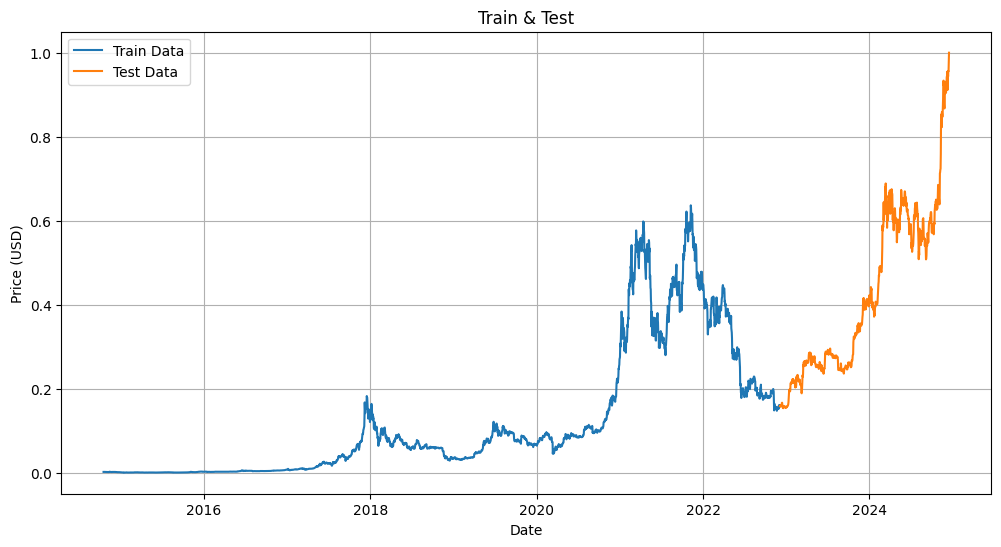

In [ ]:
# Split the data
split = int(0.80 * len(btc_data))
train_data, test_data = btc_data[0:split], btc_data[split:]

# Visualize the split
show_graph(train_data, test_data, title="Train & Test")

In [ ]:
def train_time_series_models(data):
    """
    Train AR, MA, ARMA, and ARIMA models on the Bitcoin price data.

    Args:
    data (pandas.DataFrame): Bitcoin price data.

    Returns:
    dict: Trained time series models.
    """
    # Prepare data
    price_data = data["Close"].values
    train_size = int(len(price_data) * 0.8)
    train, test = price_data[:train_size], price_data[train_size:]

    models = {}

    # AR Model
    ar_model = AutoReg(train, lags=5).fit()
    models["AR"] = ar_model

    # MA Model (implemented as ARIMA(0,0,1))
    ma_model = ARIMA(train, order=(0, 0, 1)).fit()
    models["MA"] = ma_model

    # ARMA Model
    arma_model = SARIMAX(train, order=(1, 0, 1)).fit()
    models["ARMA"] = arma_model

    # ARIMA Model
    arima_model = ARIMA(train, order=(1, 1, 1)).fit()
    models["ARIMA"] = arima_model

    return models


def evaluate_time_series_models(models, data):
    """
    Evaluate the performance of time series models.

    Args:
    models (dict): Trained time series models.
    data (pandas.DataFrame): Bitcoin price data.

    Prints:
    Performance metrics for each model.
    """
    price_data = data["Close"].values
    train_size = int(len(price_data) * 0.8)
    train, test = price_data[:train_size], price_data[train_size:]

    for name, model in models.items():
        if name == "AR":
            predictions = model.predict(
                start=len(train), end=len(price_data) - 1, dynamic=False
            )
        else:
            predictions = model.forecast(steps=len(test))

        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)

        print(f"\n{name} Model Performance:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")


def generate_time_series_predictions(models, data, steps=30):
    """
    Generate predictions using time series models.

    Args:
    models (dict): Trained time series models.
    data (pandas.DataFrame): Bitcoin price data.
    steps (int): Number of steps to forecast.

    Returns:
    dict: Predictions from each model.
    """
    predictions = {}

    for name, model in models.items():
        if name == "AR":
            pred = model.predict(
                start=len(data), end=len(data) + steps - 1, dynamic=False
            )
        else:
            pred = model.forecast(steps=steps)
        predictions[name] = pred

    return predictions

In [ ]:
def evaluate_arima_model(train, test, order):
    """
    Evaluate ARIMA model for given parameters
    """
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    mse = mean_squared_error(test, predictions)
    return predictions, mse


def calculate_accuracy(predictions, actual, model_name):
    """
    Calculate accuracy metrics for model evaluation
    """
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)

    return {"Model": model_name, "MSE": mse, "RMSE": rmse, "MAE": mae}


def predict_arima_model(data, forecast_steps, order):
    """
    Make future predictions using ARIMA model
    """
    model = ARIMA(data["Close"], order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=forecast_steps)
    return predictions


def make_future_dates(last_date, periods):
    """
    Generate future dates for predictions
    """
    return pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)


def show_graph(train_data, test_data=None, predictions=None, title=""):
    plt.figure(figsize=(12, 6))
    train_plot_data = train_data.copy()

    if isinstance(train_plot_data.index, pd.PeriodIndex):
        train_plot_data.index = train_plot_data.index.to_timestamp()
    plt.plot(train_plot_data.index, train_plot_data["Close"], label="Train Data")

    if test_data is not None:
        test_plot_data = test_data.copy()
        if isinstance(test_plot_data.index, pd.PeriodIndex):
            test_plot_data.index = test_plot_data.index.to_timestamp()
        plt.plot(test_plot_data.index, test_plot_data["Close"], label="Test Data")

    if predictions is not None:
        pred_plot_data = predictions.copy()
        if isinstance(pred_plot_data.index, pd.PeriodIndex):
            pred_plot_data.index = pred_plot_data.index.to_timestamp()
        plt.plot(
            pred_plot_data.index,
            pred_plot_data["Close"],
            label="Predictions",
            linestyle="--",
        )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'Model': 'AR Model', 'MSE': 0.12072980671221886, 'RMSE': 0.34746195002074526, 'MAE': 0.28080791695475005}


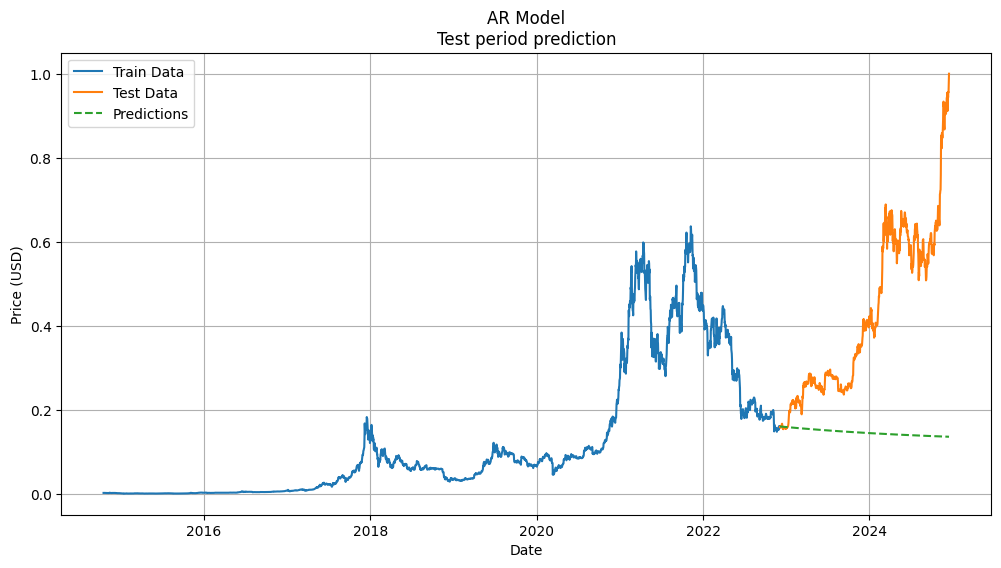

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


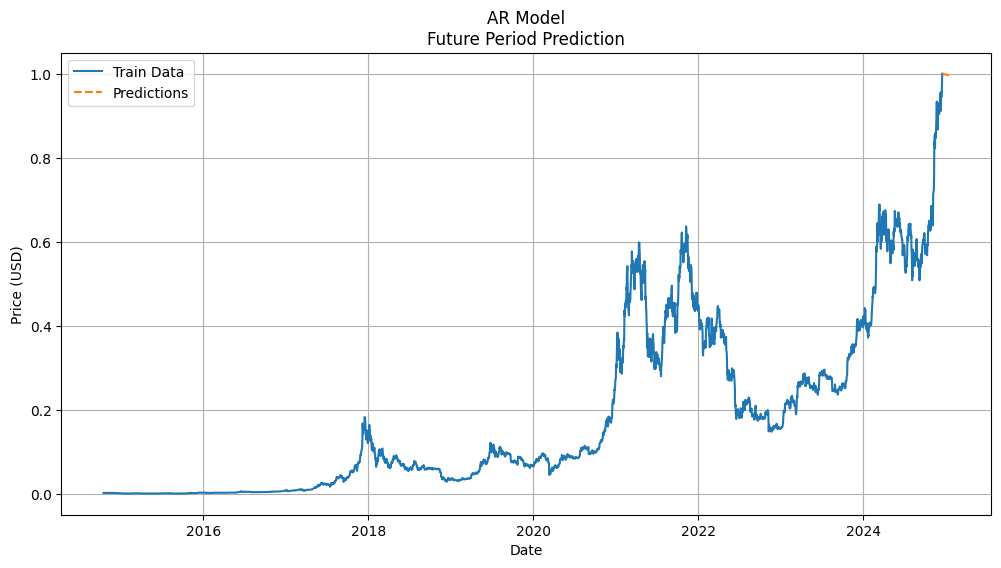

In [ ]:
# Initialize acc_sum list

acc_sum = []

# Initialize model
model_name = "AR Model"
p_values = range(1, 4)
d_values = [0]
q_values = [0]

# Make predictions
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (1, 0, 0)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Visualize test period
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Make future predictions
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
future_predictions = predict_arima_model(btc_data, len(future_dates), (1, 0, 0))
df_future_pred = pd.DataFrame({"Close": future_predictions}, index=future_dates)

# Visualize future predictions
show_graph(
    btc_data, None, df_future_pred, title=model_name + "\nFuture Period Prediction"
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'Model': 'MA Model', 'MSE': 0.1330127570028853, 'RMSE': 0.36470914027877793, 'MAE': 0.30589441365341474}


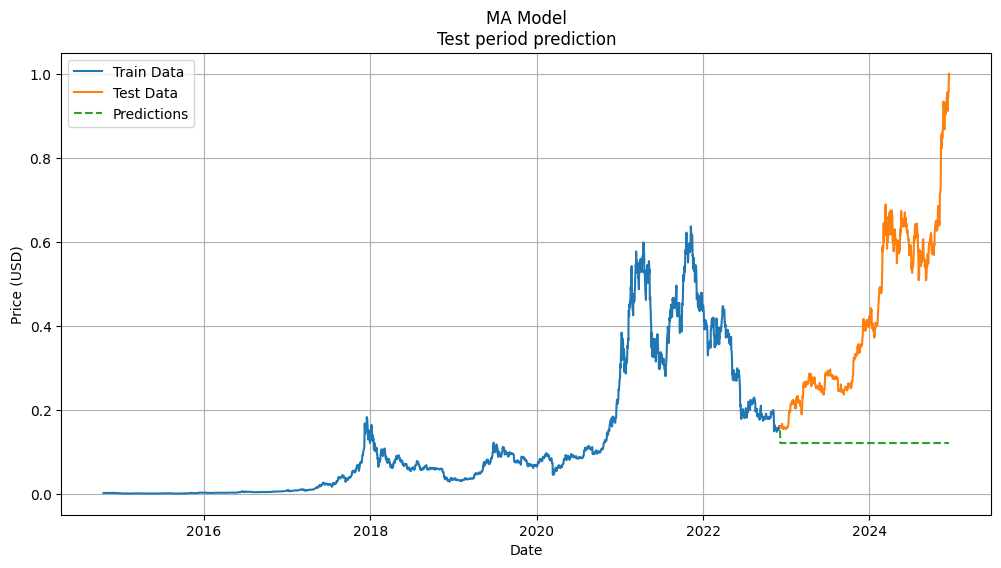

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


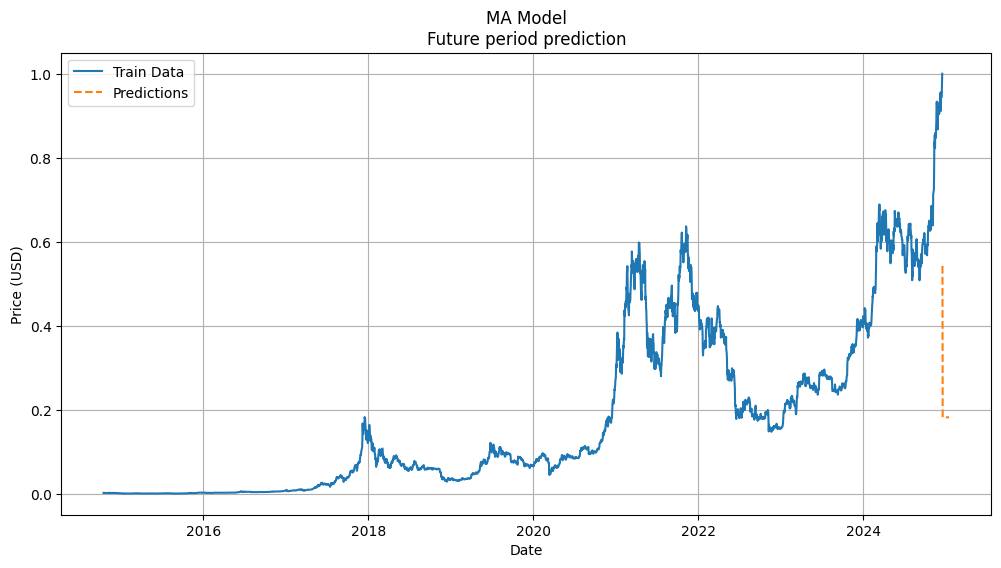

In [ ]:
model_name = "MA Model"

# Evaluate parameters
p_values = [0]
d_values = [0]
q_values = range(1, 4)

# Predict test period with best parameter
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (0, 0, 1)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate performance metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Show test period prediction
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Predict future period
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
predictions = predict_arima_model(btc_data, len(future_dates), (0, 0, 1))
df_pred = pd.DataFrame({"Close": predictions}, index=future_dates)

# Show future prediction
show_graph(btc_data, None, df_pred, title=model_name + "\nFuture period prediction")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'Model': 'ARMA Model', 'MSE': 0.12040991466058283, 'RMSE': 0.34700131795222744, 'MAE': 0.2803620406182612}


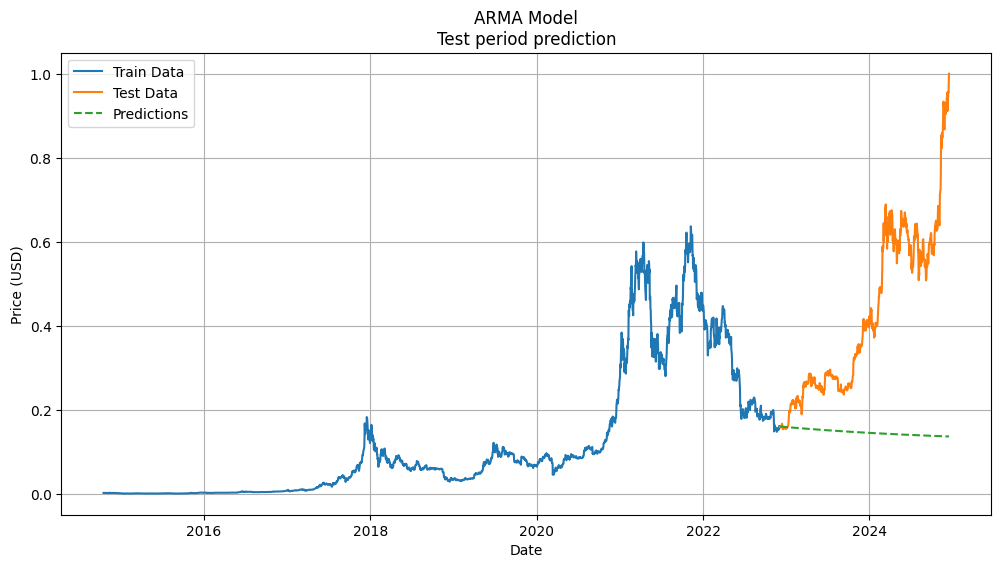

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


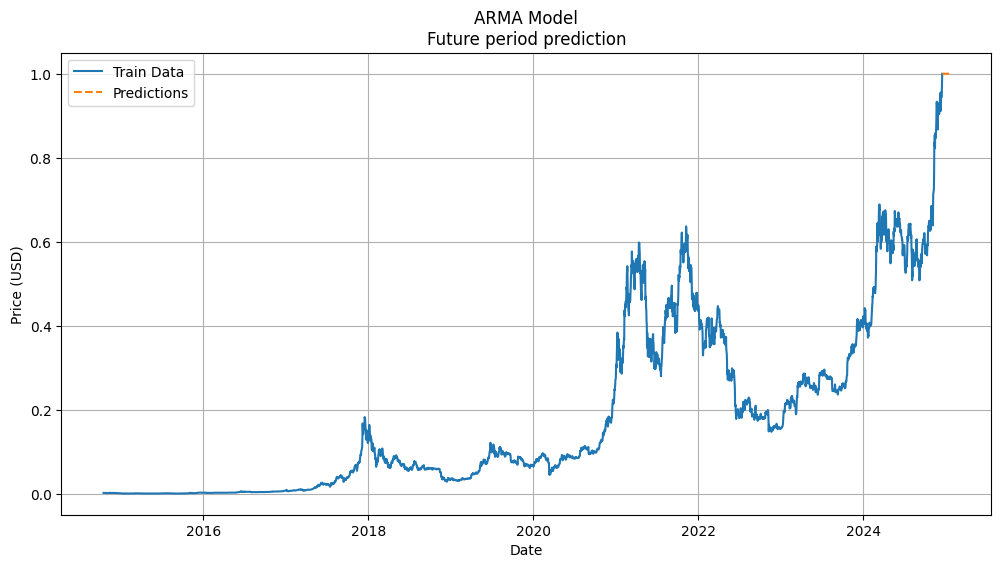

In [ ]:
model_name = "ARMA Model"

# Evaluate parameters
p_values = range(0, 1, 2)
d_values = [0]
q_values = range(0, 1, 2)

# Predict test period with best parameter
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (1, 0, 1)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate performance metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Show test period prediction
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Predict future period
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
predictions = predict_arima_model(btc_data, len(future_dates), (2, 0, 1))
df_pred = pd.DataFrame({"Close": predictions}, index=future_dates)

# Show future prediction
show_graph(btc_data, None, df_pred, title=model_name + "\nFuture period prediction")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

{'Model': 'ARIMA Model', 'MSE': 0.11040798750755237, 'RMSE': 0.33227697408570517, 'MAE': 0.2666748596101032}


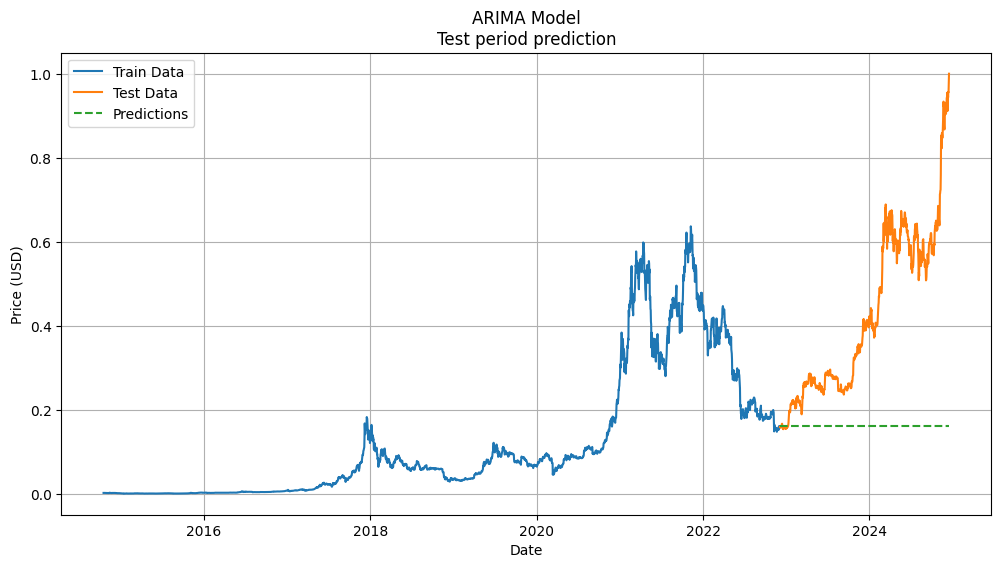

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


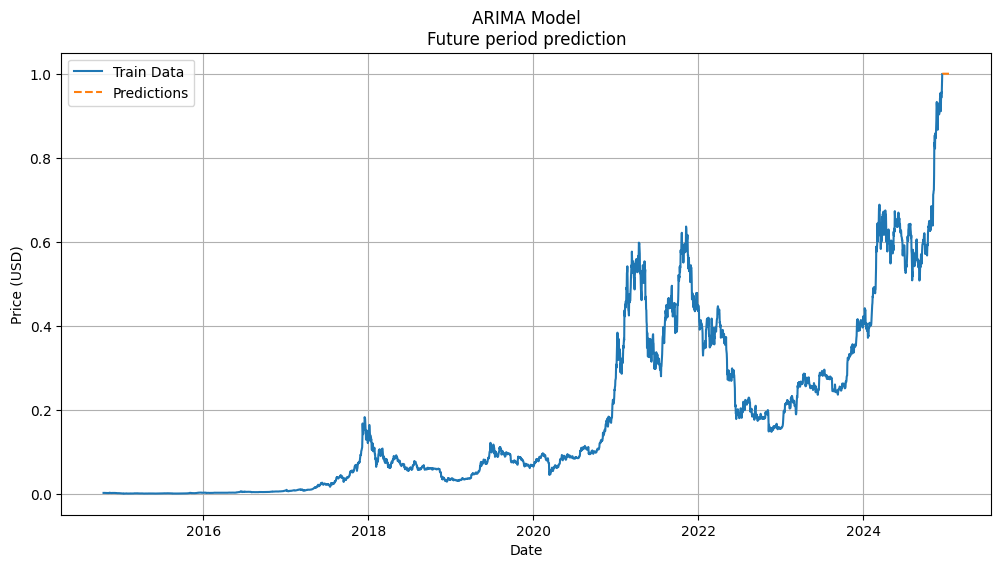

In [ ]:
model_name = "ARIMA Model"

# Evaluate parameters
p_values = [1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(1, 3)

# Predict test period with best parameter
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (2, 1, 1)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate performance metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Show test period prediction
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Predict future period
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
predictions = predict_arima_model(btc_data, len(future_dates), (2, 1, 1))
df_pred = pd.DataFrame({"Close": predictions}, index=future_dates)

# Show future prediction
show_graph(btc_data, None, df_pred, title=model_name + "\nFuture period prediction")

In [ ]:
btc_data_sum = pd.DataFrame(acc_sum)
btc_data_sum = btc_data_sum.sort_values("MAE", ascending=True)
btc_data_sum = btc_data_sum.reset_index(drop=True)
btc_data_sum

Model       MSE      RMSE       MAE
0  ARIMA Model  0.110408  0.332277  0.266675
1   ARMA Model  0.120410  0.347001  0.280362
2     AR Model  0.120730  0.347462  0.280808
3     MA Model  0.133013  0.364709  0.305894

In [ ]:
# spot check the algorithms
models = []
models.append(("LGBM", LGBMClassifier()))
models.append(("XGB", XGBClassifier()))
# Bagging method
models.append(("RF", RandomForestClassifier(n_jobs=-1)))

In [ ]:
def evaluate_models(models, X_train, Y_train, scoring="accuracy"):
    # Clean feature names to remove special characters
    X_train = X_train.copy()
    X_train.columns = [f"feature_{i}" for i in range(X_train.shape[1])]

    results = []
    names = []

    for name, model in models.items():
        cv = TimeSeriesSplit(n_splits=5)
        cv_results = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean():.3f} (+/- {cv_results.std() * 2:.3f})")

    return results, names

In [ ]:
# Define models
models = {
    "LGBMClassifier": LGBMClassifier(random_state=42),
    "XGBoostClassifier": XGBClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
}

# Evaluate models
results, names = evaluate_models(models, X_train, Y_train, scoring="accuracy")

[LightGBM] [Info] Number of positive: 263, number of negative: 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 496, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530242 -> initscore=0.121116
[LightGBM] [Info] Start training from score 0.121116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤

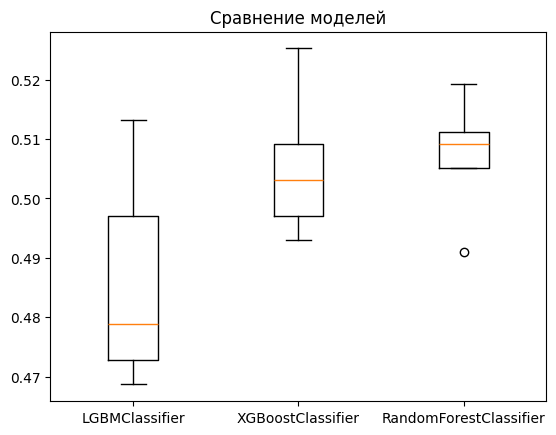

In [ ]:
# Visualize results
plt.boxplot(results, labels=names)
plt.title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π")
plt.show()

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ü–µ–Ω–∫–∏ —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–∏

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [ ]:
# Training and evaluation setup
tscv = TimeSeriesSplit(n_splits=2)

models = {
    "LGBMClassifier": LGBMClassifier(random_state=42, enable_categorical=True),
    "XGBoostClassifier": XGBClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
}

# Model training and evaluation
for name, model in models.items():
    print(f"\nEvaluating {name}")
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if name == "LGBMClassifier":
            # Convert feature names to string and replace problematic characters
            feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
            model.fit(X_train, y_train, feature_name=feature_names)
        else:
            model.fit(X_train, y_train)

        evaluate_model(model, X_test, y_test)


Evaluating LGBMClassifier
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Info] Number of positive: 696, number of negative: 542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1238, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562197 -> initscore=0.250084
[LightGBM] [Info] Start training from score 0.250084
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
Mean Squared Error: 0.4847
Mean Absolute Error: 0.4847
Recall: 0.5991
ROC AUC Score: 0.5271
F1 Score: 0.5671
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Info] Numbe

#Model Tuning

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
}

model = XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_iter=10, cv=3, random_state=42
)
random_search.fit(X_train, y_train)

print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))
means = random_search.cv_results_["mean_test_score"]
stds = random_search.cv_results_["std_test_score"]
params = random_search.cv_results_["params"]
ranks = random_search.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.519368 using {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
#5 0.517756 (0.040955) with: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01}
#10 0.513312 (0.040765) with: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
#6 0.516141 (0.042856) with: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
#8 0.513715 (0.043045) with: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.3}
#2 0.518971 (0.035312) with: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
#3 0.518967 (0.044994) with: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}
#4 0.518157 (0.046736) with: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
#1 0.519368 (0.047161) with: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
#9 0.513316 (0.040718) with: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
#7 0.515736 (0.042083) with: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.3}


In [ ]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [100, 200, 300]
max_depth = [3, 5, 7]
criterion = ["gini", "entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.526621 using {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 200}
#5 0.521777 (0.039628) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}
#4 0.521787 (0.040414) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200}
#7 0.519763 (0.040632) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 300}
#12 0.512885 (0.039625) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
#11 0.514510 (0.041478) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}
#10 0.516116 (0.038397) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 300}
#16 0.509253 (0.039892) with: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
#14 0.510868 (0.042325) with: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200}
#13 0.512482 (0.037929) with: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 300}
#3 0.522989 (0.040220) with: {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100}
#1 0.526621 (0.041704) with:

In [ ]:
param_grid = {"criterion": ["entropy"], "max_depth": [3], "n_estimators": [200]}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="precision",
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best precision score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 200}
Best precision score: 0.5452048703820895


In [ ]:
# –ò—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ª—É—á—à—É—é –º–æ–¥–µ–ª—å RandomForest
best_rf_model = grid_search.best_estimator_

# –°–æ–∑–¥–∞–Ω–∏–µ –±–∞–∑–æ–≤—ã—Ö –º–æ–¥–µ–ª–µ–π
lgbm_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

In [ ]:
def make_lgbm_safe_names(X):
    # Create safe feature names
    safe_cols = [f"col_{i}" for i in range(X.shape[1])]

    # Create mapping of original to safe names
    name_mapping = dict(zip(safe_cols, X.columns))

    # Create new dataframe with safe names
    X_safe = X.copy()
    X_safe.columns = safe_cols

    return X_safe, name_mapping


# Use the safe feature names for all models
X_safe, name_mapping = make_lgbm_safe_names(X)

stacking_model = StackingClassifier(
    estimators=[("lgbm", lgbm_model), ("xgb", xgb_model), ("rf", best_rf_model)],
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5,
)

# Fit with safe feature names
stacking_model.fit(X_safe, y)

# To make predictions later:
predictions = stacking_model.predict(X_safe)

[LightGBM] [Info] Number of positive: 1968, number of negative: 1746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529887 -> initscore=0.119690
[LightGBM] [Info] Start training from score 0.119690
[LightGBM] [Info] Number of positive: 1574, number of negative: 1397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2971, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529788 -> initscore=0.119293
[LightGBM] [Info] Start training from score 0.119293
[LightGBM] [Info] Numb

In [ ]:
X_safe, name_mapping = make_lgbm_safe_names(X)

stacking_model = StackingClassifier(
    estimators=[("lgbm", lgbm_model), ("xgb", xgb_model), ("rf", best_rf_model)],
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5,
)

stacking_model.fit(X_safe, y)

[LightGBM] [Info] Number of positive: 1968, number of negative: 1746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529887 -> initscore=0.119690
[LightGBM] [Info] Start training from score 0.119690
[LightGBM] [Info] Number of positive: 1574, number of negative: 1397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2971, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529788 -> initscore=0.119293
[LightGBM] [Info] Start training from score 0.119293
[LightGBM] [Info] Numb

StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_ty...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=3,
                                                       n_estimators=200,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [ ]:
def generate_predictions(model, last_data, future_dates, is_stacking=False):
    predictions = []
    current_data = last_data.copy()

    if is_stacking:
        # Rename columns to match what the stacking model expects
        current_data.columns = [f"col_{i}" for i in range(10)]

    for i in range(len(future_dates)):
        # Make prediction
        pred = model.predict(current_data.iloc[-1:])
        predictions.append(pred[0])

        # Update data for next prediction
        current_data = pd.concat([current_data.iloc[1:], current_data.iloc[-1:]])
        current_data.index = range(len(current_data))

    return predictions

In [ ]:
def generate_predictions(model, last_data, future_dates, is_stacking=False):
    predictions = np.zeros(len(future_dates))

    # Create initial batch data
    if is_stacking:
        # For stacking model, maintain DataFrame with proper column names
        batch_data = pd.DataFrame(
            last_data.values, columns=[f"col_{i}" for i in range(last_data.shape[1])]
        )
    else:
        # For RandomForest, use numpy array
        batch_data = last_data.values

    # Pre-allocate the full prediction batch
    prediction_batch = batch_data.copy()

    for i in range(len(future_dates)):
        if is_stacking:
            # For stacking, use full DataFrame to avoid LightGBM warnings
            predictions[i] = model.predict(prediction_batch)[0]
            # Update batch by shifting rows
            prediction_batch = pd.concat(
                [prediction_batch.iloc[1:], prediction_batch.iloc[-1:]]
            )
        else:
            predictions[i] = model.predict(prediction_batch[-1:, :])[0]
            # Update batch using numpy operations
            prediction_batch = np.roll(prediction_batch, -1, axis=0)
            prediction_batch[-1] = prediction_batch[-2]

    return predictions

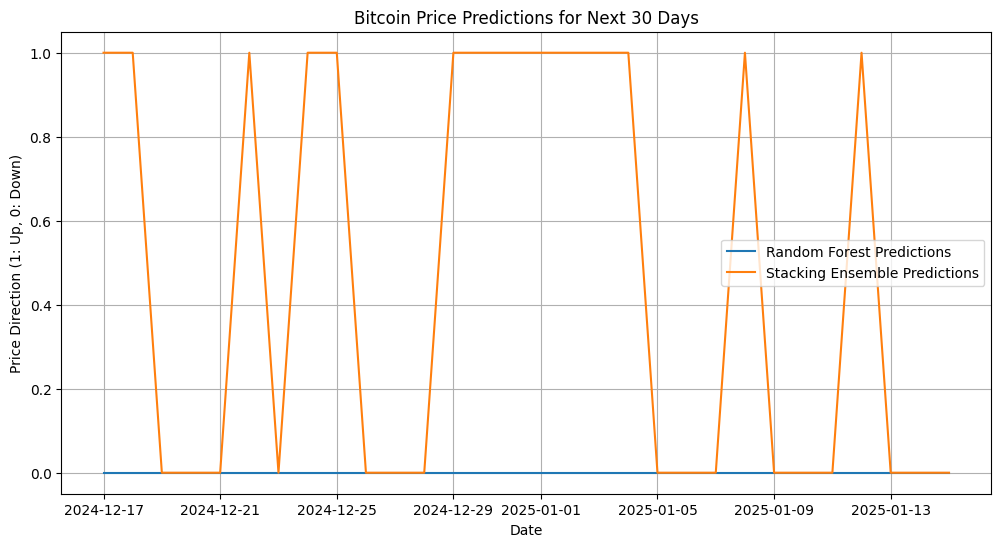

In [ ]:
# Get the last 30 days of data
last_30_days_fixed = X_train.iloc[-30:].copy()

# Ensure we use the same features as training data
feature_columns = X_train.columns
last_30_days_fixed = last_30_days_fixed[feature_columns]

# Generate predictions
rf_predictions = generate_predictions(
    model=best_rf_model,
    last_data=last_30_days_fixed,
    future_dates=future_dates,
    is_stacking=False,
)

stacking_predictions = generate_predictions(
    model=stacking_model,
    last_data=last_30_days_fixed,
    future_dates=future_dates,
    is_stacking=True,
)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, rf_predictions, label="Random Forest Predictions")
plt.plot(future_dates, stacking_predictions, label="Stacking Ensemble Predictions")
plt.title("Bitcoin Price Predictions for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Price Direction (1: Up, 0: Down)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# –ù–∞–ø–µ—á–∞—Ç–∞—Ç—å –±—É–¥—É—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑
print("\nRandom Forest Predictions:")
for date, pred in zip(future_dates, rf_predictions):
    print(f"{date.date()}: {'Up' if pred == 1 else 'Down'}")

print("\nStacking Ensemble Predictions:")
for date, pred in zip(future_dates, stacking_predictions):
    print(f"{date.date()}: {'Up' if pred == 1 else 'Down'}")


Random Forest Predictions:
2024-12-17: Down
2024-12-18: Down
2024-12-19: Down
2024-12-20: Down
2024-12-21: Down
2024-12-22: Down
2024-12-23: Down
2024-12-24: Down
2024-12-25: Down
2024-12-26: Down
2024-12-27: Down
2024-12-28: Down
2024-12-29: Down
2024-12-30: Down
2024-12-31: Down
2025-01-01: Down
2025-01-02: Down
2025-01-03: Down
2025-01-04: Down
2025-01-05: Down
2025-01-06: Down
2025-01-07: Down
2025-01-08: Down
2025-01-09: Down
2025-01-10: Down
2025-01-11: Down
2025-01-12: Down
2025-01-13: Down
2025-01-14: Down
2025-01-15: Down

Stacking Ensemble Predictions:
2024-12-17: Up
2024-12-18: Up
2024-12-19: Down
2024-12-20: Down
2024-12-21: Down
2024-12-22: Up
2024-12-23: Down
2024-12-24: Up
2024-12-25: Up
2024-12-26: Down
2024-12-27: Down
2024-12-28: Down
2024-12-29: Up
2024-12-30: Up
2024-12-31: Up
2025-01-01: Up
2025-01-02: Up
2025-01-03: Up
2025-01-04: Up
2025-01-05: Down
2025-01-06: Down
2025-01-07: Down
2025-01-08: Up
2025-01-09: Down
2025-01-10: Down
2025-01-11: Down
2025-01-12: Up

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


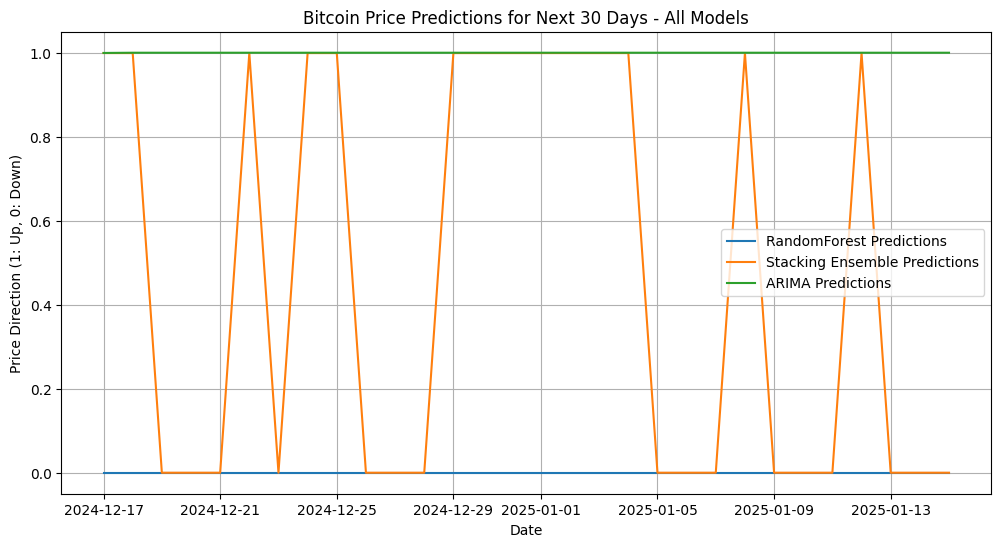

Model Predictions Summary:
RandomForest Mean: 0.0
Stacking Mean: 0.4666666666666667
ARIMA Mean: 1.0007744579571445


In [ ]:
# Generate ARIMA predictions for next 30 days
arima_predictions = predict_arima_model(btc_data, len(future_dates), (2, 1, 1))

# Create combined plot with all models
plt.figure(figsize=(12, 6))
plt.plot(future_dates, rf_predictions, label="RandomForest Predictions")
plt.plot(future_dates, stacking_predictions, label="Stacking Ensemble Predictions")
plt.plot(future_dates, arima_predictions, label="ARIMA Predictions")
plt.title("Bitcoin Price Predictions for Next 30 Days - All Models")
plt.xlabel("Date")
plt.ylabel("Price Direction (1: Up, 0: Down)")
plt.legend()
plt.grid(True)
plt.show()

# Print combined metrics
print("Model Predictions Summary:")
print("RandomForest Mean:", np.mean(rf_predictions))
print("Stacking Mean:", np.mean(stacking_predictions))
print("ARIMA Mean:", np.mean(arima_predictions))

In [ ]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—Å—á—ë—Ç–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –ø–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è–º
def print_prediction_stats(predictions, model_name):
    up_predictions = sum(predictions)
    down_predictions = len(predictions) - up_predictions

    print(f"\n{model_name} Prediction Statistics:")
    print(
        f"Up predictions: {up_predictions} ({up_predictions/len(predictions)*100:.2f}%)"
    )
    print(
        f"Down predictions: {down_predictions} ({down_predictions/len(predictions)*100:.2f}%)"
    )


print_prediction_stats(rf_predictions, "Random Forest")
print_prediction_stats(stacking_predictions, "Stacking Ensemble")
print_prediction_stats(arima_predictions, "ARIMA")


Random Forest Prediction Statistics:
Up predictions: 0.0 (0.00%)
Down predictions: 30.0 (100.00%)

Stacking Ensemble Prediction Statistics:
Up predictions: 14.0 (46.67%)
Down predictions: 16.0 (53.33%)

ARIMA Prediction Statistics:
Up predictions: 30.023233738714325 (100.08%)
Down predictions: -0.02323373871432466 (-0.08%)


In [ ]:
!autopep8 --in-place --aggressive --max-line-length 120 "/content/drive/My Drive/Colab Notebooks/Corrected Pet project Bitcoin.ipynb"

In [ ]:
!pip install black

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79.2/79.2 kB 6.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.8/1.8 MB 27.5 MB/s eta 0:00:00


In [ ]:
!pip install "black[jupyter]"

In [ ]:
!black "/content/drive/My Drive/Colab Notebooks/Corrected Pet project Bitcoin.ipynb"

All done! ‚ú® üç∞ ‚ú®
1 file left unchanged.


–í—ã–≤–æ–¥—ã:

1. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏:
–ê–Ω–∞–ª–∏–∑ –æ—Ç–≤–µ—Ä–≥–∞–µ—Ç –≥–∏–ø–æ—Ç–µ–∑—É –æ —Ç–æ–º, —á—Ç–æ –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç—å –±–∏—Ç–∫–æ–∏–Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ. –ù–µ–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç, —á—Ç–æ —Ç—Ä–∞–¥–∏—Ü–∏–æ–Ω–Ω—ã–µ —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã–µ –º–æ–¥–µ–ª–∏, –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞—é—â–∏–µ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ, –º–æ–≥—É—Ç –Ω–µ –ø–æ–¥—Ö–æ–¥–∏—Ç—å –¥–ª—è –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è –∫—É—Ä—Å–∞ –±–∏—Ç–∫–æ–∏–Ω–∞, —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ —É–ø—Ä–∞–≤–ª–µ–Ω–∏—è —Ä–∏—Å–∫–∞–º–∏ –¥–æ–ª–∂–Ω—ã —É—á–∏—Ç—ã–≤–∞—Ç—å —ç—Ç—É —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫—É.

2. –°–≤—è–∑—å –æ–±—ä–µ–º–∞ –∏ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏:
–í –¥–∞–Ω–Ω–æ–º –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–∏ –±—ã–ª–∞ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∞ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –º–µ–∂–¥—É –æ–±—ä–µ–º–æ–º —Ç–æ—Ä–≥–æ–≤–ª–∏ –∏ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å—é —Ü–µ–Ω—ã. –≠—Ç–æ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –≤–∞–∂–Ω–æ—Å—Ç—å –æ–±—ä–µ–º–∞ –∫–∞–∫ –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞ —Ä—ã–Ω–æ—á–Ω–æ–π –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏ –∏ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö –¥–≤–∏–∂–µ–Ω–∏–π —Ü–µ–Ω—ã. –¢—Ä–µ–π–¥–µ—Ä—ã –∏ –∞–Ω–∞–ª–∏—Ç–∏–∫–∏ –¥–æ–ª–∂–Ω—ã —É—á–∏—Ç—ã–≤–∞—Ç—å –æ–±—ä–µ–º –Ω–∞—Ä—è–¥—É —Å —Ü–µ–Ω–æ–π –ø—Ä–∏ –æ—Ü–µ–Ω–∫–µ —Ä—ã–Ω–æ—á–Ω—ã—Ö —É—Å–ª–æ–≤–∏–π.

3. –ü–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ —Å—Ä–µ–¥–Ω–µ–π —Å–∫–æ–ª—å–∑—è—â–µ–π:
–ë—ã–ª–∞ –ø—Ä–æ–≤–µ—Ä–µ–Ω–∞ –≥–∏–ø–æ—Ç–µ–∑–∞ –æ —Ç–æ–º, —á—Ç–æ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ 7-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π –≤—ã—à–µ 30-–¥–Ω–µ–≤–Ω–æ–π —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π —è–≤–ª—è–µ—Ç—Å—è –Ω–∞–¥–µ–∂–Ω—ã–º —Å–∏–≥–Ω–∞–ª–æ–º –∫ ‚Äã‚Äã–ø–æ–∫—É–ø–∫–µ. –≠—Ç–æ –æ—Ç–∫—Ä—ã—Ç–∏–µ –º–æ–∂–µ—Ç —Å—Ç–∞—Ç—å –≤–∞–∂–Ω—ã–º —Ñ–∞–∫—Ç–æ—Ä–æ–º –ø—Ä–∏ –ø—Ä–∏–Ω—è—Ç–∏–∏ —Ä–µ—à–µ–Ω–∏—è –æ –ø–æ–∫—É–ø–∫–µ –±–∏—Ç–∫–æ–∏–Ω–∞.

4. –≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏:
–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ Random Forest –∏ Stacking Ensemble –ø–æ–∫–∞–∑–∞–ª–æ, —á—Ç–æ –º–µ—Ç–æ–¥—ã –∞–Ω—Å–∞–º–±–ª—è . –≠—Ç–æ –≥–æ–≤–æ—Ä–∏—Ç –æ —Ç–æ–º, —á—Ç–æ –º–µ—Ç–æ–¥—ã –∞–Ω—Å–∞–º–±–ª—è –º–æ–≥—É—Ç —Å—Ç–∞—Ç—å —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã–º –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–º –≤ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–∏ —Ü–µ–Ω—ã –ë–∏—Ç–∫–æ–∏–Ω–∞.

5. –ö—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω–∞—è –ø—Ä–µ–¥—Å–∫–∞–∑—É–µ–º–æ—Å—Ç—å:
 –ú–æ–¥–µ–ª–∏ –ø—Ä–æ–¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä–æ–≤–∞–ª–∏ –Ω–µ–∫–æ—Ç–æ—Ä—É—é —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞—Ç—å –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –¥–≤–∏–∂–µ–Ω–∏—è —Ü–µ–Ω—ã Bitcoin –≤ —Ç–µ—á–µ–Ω–∏–µ 30-–¥–Ω–µ–≤–Ω–æ–≥–æ –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞. –û–¥–Ω–∞–∫–æ —Ç–æ—á–Ω–æ—Å—Ç—å —ç—Ç–∏—Ö –ø—Ä–æ–≥–Ω–æ–∑–æ–≤ –ø–æ–¥—á–µ—Ä–∫–∏–≤–∞–µ—Ç —Å–ª–æ–∂–Ω—É—é –ø—Ä–∏—Ä–æ–¥—É –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è —Ü–µ–Ω—ã –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç—ã.